**<font size=6>手写数字识别案例</font>**

In [1]:
import numpy as np
import pandas as pd

**<font size=5>1. 加载数据</font>**

In [2]:
from sklearn.datasets import load_digits
mnist = load_digits()

本来要使用fetch_openml("mnist_784", version=1)这种方式获取手写数字，但是下载速度太慢了，所以使用sklearn自带的手写数字数据集

这种方式会在线下载手写数字的数据集，默认下载在$HOME/scikit_learn_data中

这时候得到的mnist数据集是一个字典形式的，可以通过键来查看它有哪些信息

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

对其中的键做一些解释：<br>
**data**  ：特征数组（一行代表一个样本实例，一列代表一个特征）<br>
**target**  ：目标label，ndarray数组类型<br>
**feature_names**  ：特征名<br>
**DESCR**  ：对数据集的一些描述信息

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((1797, 64), (1797,))

一共有1791条数据，代表了1791个图像，每个图像有64个特征，因为这些图像是8*8像素，每个特征表示从0（白色）到255（黑色）之间的一个像素强度。

如果想要查看其中的一张图像，可以重新reshape这条数据的大小，reshape（（8,8））,然后利用Matplotlib的imshow()将其展示出来即可

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

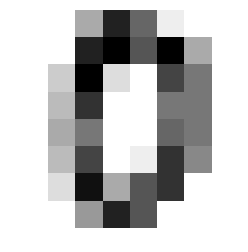

In [7]:
digit_example = X[0]
example_image = digit_example.reshape(8,8)
plt.imshow(example_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[0]

0

可以发现label和特征图像对应<br>
更为复杂的数据情况，如下图所示：

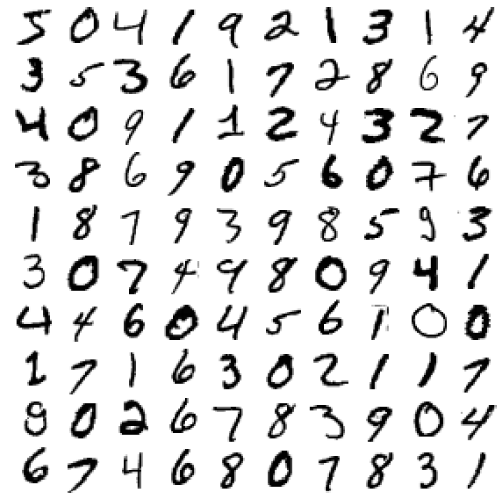

划分数据集，80%作为训练集，20%作为测试集

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [11]:
X_train.shape, X_test.shape

((1437, 64), (360, 64))

使用随机的split，可以确保在训练集中各种类型的数据都有。如果使用顺序split，一些对顺序敏感的顺序算法可以会依赖实例，这样的话，在其他实例上运行，它们的性能就会变得很差

**<font size=5>2. 尝试训练一个二分类器</font>**

例如可以识别5和非5的手写数字图像

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5和y_test_5是两个bool类型的数组，等于5的值为True，其他为False

选择一个分类器并对其进行训练。 一个不错的起点是使用Scikit-Learn的SGDClassifier类进行的随机梯度下降（SGD）分类器。 该分类器的优势在于能够有效处理非常大的数据集。 部分原因是SGD一次单独处理一个训练实例（这也使SGD非常适合在线学习），我们将在后面看到。 让我们创建一个SGDClassifier并在整个训练集中对其进行训练：

In [13]:
from sklearn.linear_model import SGDClassifier

    考虑到随机梯度下降会受到随机性的影响，即stochastic，为了保证运行结果的一致，可以设置random_state参数

In [14]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

查看SGD分类器在测试集上的效果

In [15]:
y_test_pred = sgd.predict(X_test)

In [16]:
result = (y_test_pred == 5) == (y_test_5 == 5)

In [17]:
sum(result == True)/X_test.shape[0]

1.0

可以发现全部分类正确

**<font size=5>评估模型性能</font>**

<font color="red">分类型模型的评估比数值型模型的评估要复杂一些，会用到很多的评价指标</font>

**<font size=4>使用交叉验证评估accuracy</font>**

评估模型的一种好方法是使用交叉验证<br>
**<font color="red">一定要注意的是，交叉验证仅在训练集上进行</font>**

首先，可以尝试自己实现一个cross_validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

StratifiedKFold类执行分层采样以产生包含每个类的代表性比率的折。 在每次迭代时，代码都会创建分类器的克隆，在训练折上进行克隆训练，并在测试折上进行预测。 然后，它计算正确预测的数量并输出正确预测的比率。

In [19]:
skfold = StratifiedKFold(n_splits=3, random_state=42)

In [20]:
scores = []

In [21]:
for train_index, test_index in skfold.split(X_train, y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    accuracy = n_correct / len(y_pred)
    print("accuracy：", accuracy)
    scores.append(accuracy)

accuracy： 0.9979166666666667
accuracy： 0.9874739039665971
accuracy： 0.9916317991631799


计算K折上score的均值：

In [22]:
sum(scores) / len(scores)

0.9923407899321478

一般，会使用sklearn直接提供的cross_val_score()来实现三折交叉验证

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.99791667, 0.9874739 , 0.9916318 ])

可以发现和我们手动写的实现代码的结果基本一致

结果有些优秀，我们使用一个预测结果为全0的基类估计器查看一下

In [25]:
from sklearn.base import BaseEstimator

定义一个估计器，输出的预测结果全为False，就是估计的结果是：都不是5

In [26]:
class Never5Classifer(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [27]:
never_5_clf = Never5Classifer()

In [28]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.87891441, 0.89561587, 0.91022965])

结果出乎意料，居然达到了90%。

<font color="red">因为只有10%的数据是5，所以摆在面前的数据集是一个严重不平衡的数据集，就不能再使用accuracy</font>

**<font color="red" size=4>其实，对于分类型模型来说，accuracy不是一个很好的评估指标</font>**

**<font size=4>使用混淆矩阵评估Confusion Matrix</font>**

要计算混淆矩阵，您首先需要具有一组预测，以便可以将它们与实际目标进行比较。

就像cross_val_score（）函数一样，cross_val_predict（）执行K折交叉验证，但是它不返回评估分数，而是返回在每个测试折中做出的预测。<br>这意味着您将获得训练集中每个实例的干净预测（“干净”表示该预测是由训练期间从未看到数据的模型做出的预测）

**<font color="red">就是说，第一部分的数据，使用第二折和第三折训练模型预测得到的；第二部分，使用第一折和第三折训练模型得到的,...以此类推。</font>**

In [29]:
from sklearn.model_selection import cross_val_predict

In [30]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [31]:
y_test_pred.shape

(360,)

之后利用真实值和预测值计算混淆矩阵

In [32]:
from sklearn.metrics import confusion_matrix

TP:真正例True positive<br>
FN:假反例False negative<br>
FP:假正例False positive<br>
TN:真反例True negative

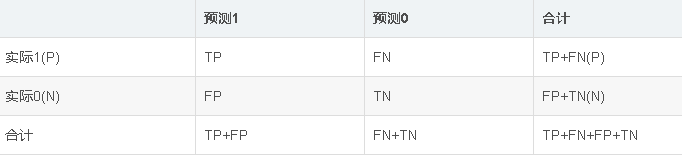

In [33]:
confusion_matrix(y_train_5, y_train_pred)

array([[1281,    5],
       [   6,  145]], dtype=int64)

每一行代表一个实际类别，每一列代表预测类别。第一行考虑非5的数据，其中1289个被正确分类，6个被错误分类。第二行考虑正5类别的数据，其中9个被错误分类，133个被正确分类。

一个完美的分类器将只有真正值和真负值，因此其混淆矩阵仅在其主对角线上（左上至右下）具有非零值

In [34]:
confusion_matrix(y_train_5, y_train_5)

array([[1286,    0],
       [   0,  151]], dtype=int64)

**分类器精度precision**

**<font color="red">precision是对预测而言</font>**

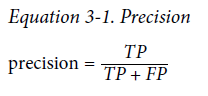

TP是真阳性的数量，FP是假阳性的数量。即预测为阳性的数据中，真正阳性所占的比例

精度通常与另一个称为召回率的指标（也称为灵敏度或真实阳性率）一起使用

高precesion表明，每次只将有把握的预测类划分到正类中

**召回率recall**

<font color="red">召回率是对原始label为正例的样本而言的</font>

这是分类器正确检测到的阳性实例的比率

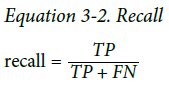

TP真阳性率，FN假阴性率。即所有真实类别是阳性的数据中，预测为阳性的数据所占的比例

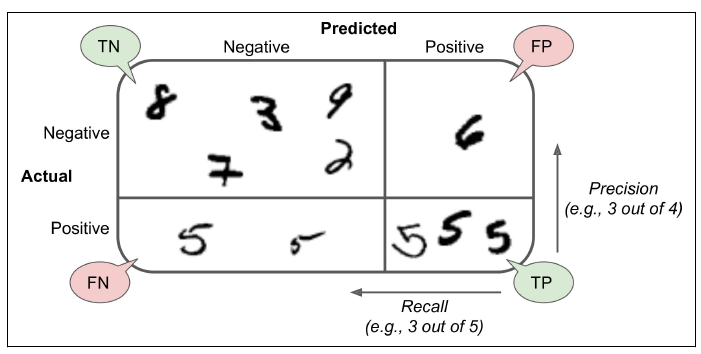

scikit-learn中提供的计算precision和recall的方法

In [35]:
from sklearn.metrics import precision_score, recall_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.9666666666666667

In [37]:
recall_score(y_train_5, y_train_pred)

0.9602649006622517

可以发现precision的结果并不想accuracy看上去那么理想

**F1score**

F1score是precesion和recall的调和平均值，只有当precesion和recall都很高时，F1score也很高。

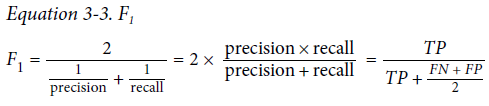

In [38]:
from sklearn.metrics import f1_score

In [39]:
f1_score(y_train_5, y_train_pred)

0.9634551495016612

f1sccore无法兼顾recall和precesion，recall高precesion必然会低。反之亦然

**Precision/Recall tradeoff**

对于每个实例，它都基于决策函数计算得分，如果该得分大于阈值，则将实例分配给阳性类别，否则将其分配给阴性类别

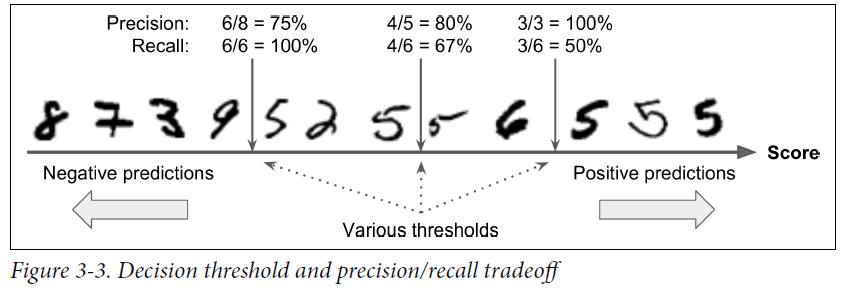

可以选择一个阈值，来中和recall和precision

In [40]:
from sklearn.model_selection import cross_val_predict

In [41]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

查看每个实例的相应分数

利用这些score，结合precision_recall_curve()来计算出所有可能的recall与precision

In [42]:
from sklearn.metrics import precision_recall_curve

In [43]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

In [44]:
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    fig = plt.figure(figsize=(20,10))
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.title("precision and recall change with different thresholds")
    plt.xlabel("thresholds")
    plt.ylabel("evaluator score")
    plt.legend()
    plt.show()

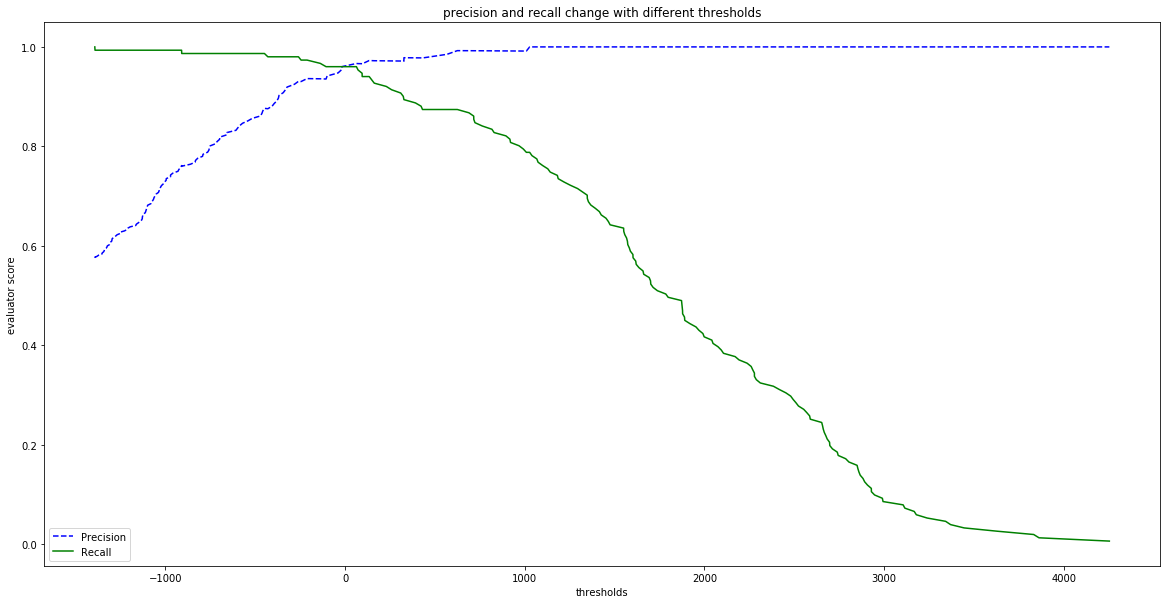

In [45]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

为什么recall的值在开始的时候比precision高?开始的时候，阈值较低，将所有类别都划分为正例，所以recall值高，而这些实例其实不是真实的正例，所以precision较低

直接查看precision随召回率变化的图像

In [46]:
def plot_precision_vs_recall(precision, recall):
    fig = plt.figure(figsize=(20,10))
    plt.plot(precision[:-1], recall[:-1], "r-")
    plt.title("recall change with different thresholds")
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()

绘制PR曲线

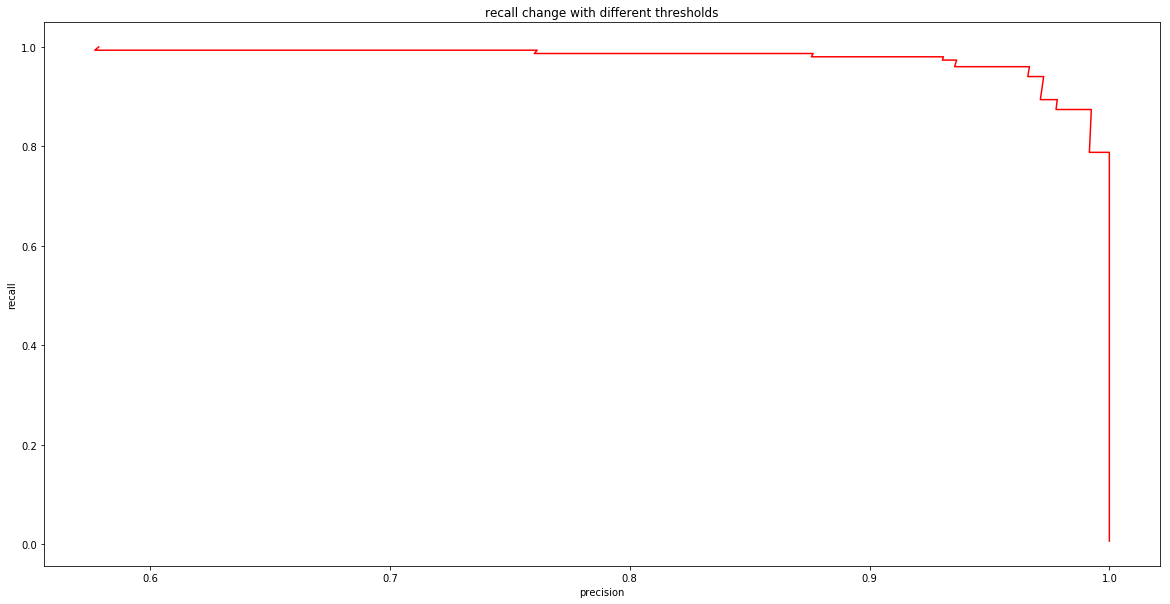

In [47]:
plot_precision_vs_recall(precision, recall)

可以发现precision到达0.9左右的时候，recall会大幅下降。

找到使得precision>=0.9的阈值

In [48]:
thresholds_90_precision = thresholds[np.argmax(precision >= 0.9)]

np.argmax()返回的是precision>=0.9的下标

利用使得precision大于等于0.9的阈值作为分类器的阈值

In [49]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [50]:
precision_score(y_train_5, y_train_pred_90)

0.9024390243902439

In [51]:
recall_score(y_train_5, y_train_pred_90)

0.9801324503311258

**<font color="red">如果有人说，我的分类器precision达到了90%,那你可以问他，recall值是多少？hiahiahia</font>**

**<font size=4>使用ROC曲线</font>**

受试者工作特性（ROC）曲线是与二进制分类器。 它与精确度/召回率曲线非常相似，但是ROC曲线不是绘制精确度与召回率，而是绘制真阳性率（召回率的别称）与假阳性率的比值。 FPR是被错误分类为阳性的阴性实例的比率。 它等于1减去真阴性率。TNR真阴性率是类别为阴性的数据有多少被预测为阴性，TNR也称为特异性。<br> 因此，ROC曲线绘制了灵敏度（召回率）与1 –特异性的关系。

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

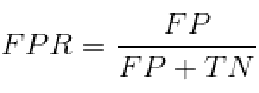

In [54]:
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--", label="random classifier")
    plt.title("ROC Curve")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()

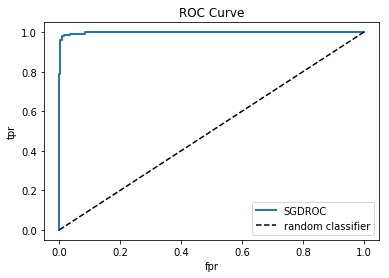

In [55]:
plot_roc(fpr, tpr, "SGDROC")

召回率recall(TPR)越高, FPR也越高

其中的虚线，表示纯随机分类器的ROC曲线。好的分类器应该更靠近左上角

**AUC**<br>
Area under curve,ROC曲线下的面积。完美分类器的AUC值为1，随机分类器的AUC为0.5

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9985889816979596

**可以发现ROC和PR(precision-recall)很像，那么使用哪种好呢？**

当实例中的正例很少，我们会更关心假正例FP，而不是假反例FN，所以会选择PR曲线。

例如，查看以前的ROC曲线（和ROC AUC得分），您可能会认为分类器确实不错。但这主要是因为与与非5的数据相比，真实为5的数据太少。相反，PR曲线清楚地表明分类器还有改进的空间（该曲线可能更靠近右上角）

**<font size=5>3. 使用随机森林分类器作为预测模型</font>**

随机森林分类器没有decision_function()方法，但是它有**predict_proba()**方法。<br>
predict_proba()方法返回一个数组，其中每个实例一行，每列代表该实例属于该类别的概率

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest_clf = RandomForestClassifier(random_state=42)

In [59]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


但是绘制ROC曲线，需要score而不是概率值，需要对概率值做一些处理。可以使用正例的概率作为score

In [60]:
y_scores_forest = y_probas_forest[:,1]

In [61]:
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

Text(0,0.5,'tpr')

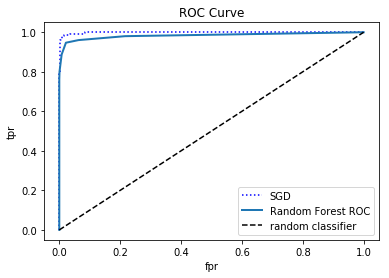

In [62]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc(fpr_forest, tpr_forest, "Random Forest ROC")
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")


In [63]:
roc_auc_score(y_train_5, y_scores_forest)

0.9833201157652972

通过图像发现，SGD随机梯度下降可能更适用一些

希望你现在知道如何训练二分类模型，选择适合相应任务的评估指标，使用交叉验证评估分类器，选择适合您需求的精度/recall权衡，以及使用ROC曲线和ROC-AUC得分比较各种模型。

**<font size=5>4. 多分类</font>**

例如，创建可将数字图像分类为10类（从0到9）的系统的一种方法是训练10个二分类器，每个数字训练一个二分类器（0探测器，1探测器，2探测器等等）。就像上面刚刚对5进行分类一样。 然后，当您要对图像进行分类时，可以从该图像的每个分类器中获得决策得分，然后选择其分类器输出最高得分的类。 这就是所谓的“一对所有”（OvA）策略（也称为“一对其余”）。

还有一种方法采用一对一(OvO策略)，对每个数字组合训练一个二分类器，例如训练一个分类器用于区分0和1，训练一个分类器用于区分0和2，...。如果有N个类别，需要训练N(N-1)/2个分类器。对于拥有10个类别的MNIST数据集，要训练10*9/2=45个分类器通过所有45个分类器，查看哪个类别赢得更高的分数。 OvO的主要优点是，每个分类器仅需要针对必须区分的两个类别的训练集进行训练。

Scikit-Learn会检测到何时尝试将二进制分类算法用于多类分类任务，并且会自动运行OvA（使用OvO的SVM分类器除外）。 让我们使用SGDClassifier尝试一下：

In [64]:
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
sgd.predict([X_train[0]])

array([6])

Scikit-Learn实际上训练了10个二元分类器，获得了图像的决策分数，并选择了分数最高的类别。

In [66]:
test_digit_scores = sgd.decision_function([X_train[0]])

In [67]:
y_train[0]

6

In [68]:
test_digit_scores

array([[-2998.95150653, -1432.86393309, -4665.59066601, -2123.76561977,
        -2079.56052931, -1867.96774616,  2505.21717375, -3126.98614304,
        -1753.40050713, -2278.58505598]])

In [69]:
np.argmax(test_digit_scores)

6

可以看到分类为0

使用sgd.classes_属性可以查看SGD模型的类别数

训练分类器时，它会将目标类的列表按值排序存储在其classes_属性中。 在这种情况下，classes_数组中每个类的索引都方便地与该类本身匹配（例如，索引5处的类恰好是5类），但是总的来说，您不会很幸运。

In [70]:
sgd.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**如果想要创建一对一分类器**<br>
使用sklearn中的OneVsOneClassifier方法，将二分类器传入即可

In [71]:
from sklearn.multiclass import OneVsOneClassifier

In [72]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [73]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

使用estimators_属性可以查看相应的估计器

In [74]:
len(ovo_clf.estimators_)

45

如果使用的是随机森林分类的话，就不必考虑OvO或OvA，因为随机森林分类器可以将实例直接分类为多个类。

In [75]:
forest_clf.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [76]:
y_train[0]

6

可以使用predict_proba()查看分类器划分到多个类中的概率

In [77]:
forest_clf.predict_proba([X_train[0]])

array([[0. , 0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. , 0. ]])

**<font size=4>评估分类器</font>**

使用交叉验证评估随机森林模型

In [78]:
cvscore = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

In [79]:
cvscore.mean()

0.9249058079145861

对数据进行一下标准化之后再看一下结果

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
scaler = StandardScaler()

In [82]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [83]:
cvscaledscore = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [84]:
cvscaledscore.mean()

0.9235283974462666

精度提高了一丢丢

**<font size=5>5. 误差分析</font>**

利用GridSearchCV网格搜索调整其超参数，然后分析错误原因去提高模型的拟合效果。

**<font size=4>首先，可以看下混淆矩阵</font>**

In [85]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)

In [86]:
confusionMatrix = confusion_matrix(y_train, y_train_pred)
confusionMatrix

array([[146,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 132,   1,   1,   1,   0,   1,   0,   2,   3],
       [  1,   1, 131,   2,   0,   1,   0,   0,   3,   0],
       [  0,   0,   1, 135,   0,   5,   0,   2,   5,   0],
       [  0,   2,   0,   0, 139,   0,   0,   1,   2,   1],
       [  0,   0,   0,   1,   0, 146,   0,   0,   2,   2],
       [  0,   1,   0,   0,   0,   1, 142,   0,   2,   0],
       [  0,   0,   0,   1,   1,   0,   0, 131,   3,   3],
       [  0,   6,   0,   2,   0,   1,   0,   1, 127,   2],
       [  0,   1,   0,   2,   0,   1,   0,   1,   9, 128]], dtype=int64)

可以绘制热力图查看混淆矩阵中的信息

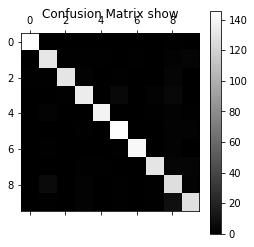

In [87]:
plt.matshow(confusionMatrix, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Confusion Matrix show")
plt.show()

通过图像可以看到了对角线上的元素颜色较浅，表示数量较多，而其他位置的颜色较深，表示错分的数据较少

**关注混淆矩阵中错分的数据**<br>
首先将混淆矩阵中的每个值除以相应类别的图像数，这样可以查看相对错误率

In [88]:
row_sums = confusionMatrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusionMatrix / row_sums

In [89]:
type(norm_conf_mx)

numpy.ndarray

将错误率数组中对角线上的元素用0填充，只保留分错的数据情况

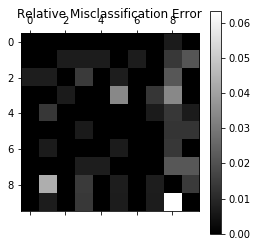

In [90]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Relative Misclassification Error")
plt.colorbar()
plt.show()

现在可以清晰地看到分类器产生的各种错误，行代表真实类别，列代表预测类别。<br>
还可以发现，混淆矩阵不一定是对称的。

混淆矩阵可以帮助我们了解如何改进分类器，有时候这样很麻烦而且耗时。

可以发现8和1的错误率较高，查看一下1和8的一些例子

In [91]:
cl_a, cl_b = 1, 8

In [92]:
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [93]:
X_aa.shape

(132, 64)

查看几个错分的实例

**错分为8的实例1**

In [94]:
def showDigits(data):
    data_image = data.reshape(8,8)
    plt.imshow(data_image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

In [98]:
X_ab.shape

(2, 64)

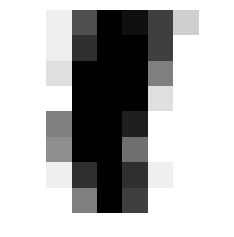

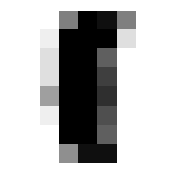

In [100]:
plt.figure(figsize=(8,8))
plt.subplot(121)
showDigits(X_ab[0])
plt.subplot(122)
showDigits(X_ab[1])
plt.show()


**查看错分为1的实例8**

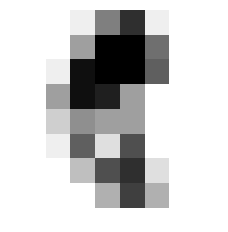

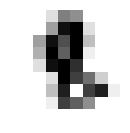

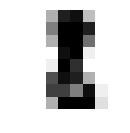

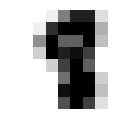

In [101]:
plt.figure(figsize=(8,8))
plt.subplot(221)
showDigits(X_ba[0,:])
plt.subplot(222)
showDigits(X_ba[1,:])
plt.subplot(223)
showDigits(X_ba[2,:])
plt.subplot(224)
showDigits(X_ba[3,:])

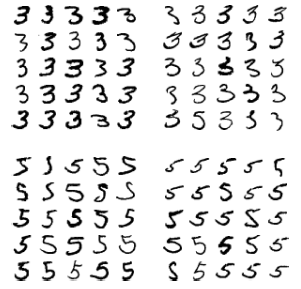

有些图像，即使是人类也无法良好的识别。因为我们使用了线性模型SGD，它为每个像素分配一个类别权重，预测时将这些权重加和。由于1和8、3和5只有个别的像素点不同，因此很容易识别错误。

线性分类器对图像的移位和旋转非常敏感，可以在训练之前，通过对图像进行一些调整，来提高模型的拟合精度

**<font size=5>6. 多标签分类</font>**

目前的实例对应一个标签，如果我们正在进行人脸识别，一张图片中出现了三个人：Kylin、Ysl和Bland，那要怎么进行标记？【1,1,1】<br>
输出多二进制标签的分类系统就称为multilabel classification system

In [102]:
from sklearn.neighbors import KNeighborsClassifier

手动生成一个多标签数组，每个数组包含两个目标标签：<br>
    第一个指示该数字是否很大？(7、8、9)<br>
    第二个指示它是否是奇数？

In [121]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

KNN分类器支持多标签分类<br>
**<font color="red">(注：并非所有的分类器都支持多分类)</font>**

In [122]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [123]:
y_train[0]

6

In [124]:
knn.predict([X_train[0]])

array([[False, False]])

结果表明，6不是奇数，也不是偶数

In [125]:
y_train[4]

7

In [126]:
knn.predict([X_train[4]])

array([[ True,  True]])

这个结果它显示7是大数，而且7是奇数

**<font size=4>评估多label分类器</font>**

评估多label分类器的指标：F1score测量每个单独标签的F1score，然后计算均值

In [127]:
y_train_knn_pred = cross_val_predict(knn, X_train, y_multilabel, cv=3)

In [128]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9816488172160139

这种方式假定所有label都同等重要，事实上可能并非如此。可以通过修改average=“weighted”,将所有标签的权重按照该目标标签拥有的实例数进行赋值。

对于f1_score中的average参数：<br>
**这里需要注意**<br>
如果是二分类问题,则选择参数"binary"<br>
如果考虑类别的不平衡性，需要计算类别的加权平均,则使用"weighted"<br>
如果不考虑类别的不平衡性，计算宏平均，则使用"macro"

**<font size=5>7. 多输出分类</font>**

多输出分类只是多标签分类的概括，其中每个标签可以是多类的（即，它可以具有超过两个以上的值）

为了说明这一点，让我们建立一个消除图像噪音的系统。 它将输入一个有噪声的数字图像，并且（希望）输出一个干净的数字图像，该图像以像素强度数组的形式表示，就像MNIST图像一样。 请注意，分类器的输出是多标签（每个像素一个标签），每个标签可以有多个值（像素强度范围为0到255）。 因此，它是多输出分类系统的示例。

例如，在此示例中，分类和回归之间的界限有时是模糊的。 可以说，预测像素强度更类似于回归而不是分类。 而且，多输出
系统不限于分类任务； 您甚至可能拥有一个系统，该系统每个实例输出多个标签，包括类标签和值标签。

**①添加噪声**

In [177]:
noise = np.random.randint(0, 25, (len(X_train), 64))
X_train_noised = X_train + noise

In [178]:
noise2 = np.random.randint(0, 25, (len(X_test), 64))
X_test_noised = X_test + noise2

In [179]:
y_train_mod = X_train

In [180]:
y_test_mod = X_test

**②查看原始图片**

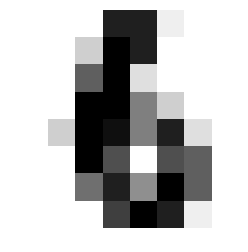

In [181]:
showDigits(X_train[0])

查看一下添加噪声后的图片

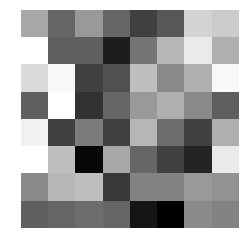

In [182]:
showDigits(X_train_noised[0])

**③拟合KNN模型**

In [183]:
knn.fit(X_train_noised, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [184]:
X_train_noised[0].shape

(64,)

**④查看利用KNN清洗噪声的情况**

In [185]:
clean_digit = knn.predict([X_train_noised[0]])

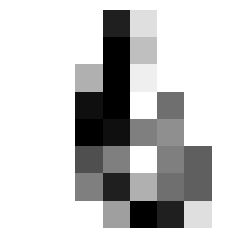

In [186]:
showDigits(clean_digit)

可以发现结果还是不错滴